# 3. Numerical integration

Numerical integration is a straightforward implementation. This phenomenon can be expressed mathematically as:



$n_{\text{points}} \sim \prod_{j=1}^{d} n_{\text{grids}} = n_{\text{grids}}^{d}$

where: 
- $ n_{\text{points}} $: Represents the number of points.
- $ \prod_{j=1}^{d} n_{\text{grids}} $: Indicates the product of $ n_{\text{grids}} $ from $ j=1 $ to $ d $.
- $ n_{\text{grids}}^{d} $: Shows that the number of grids is raised to the power of $ d $.


However, "the curse of dimensionality" exists.



```{figure} ../figures/numericalintegration.png
:alt: numerical integration example
:width: 500px
:align: center
"A Conceptual Introduction to Markov Chain Monte Carlo Methods", Joshua Speagle (2019)
```



````{exercise}
:label: exercise3
:number: 3


Estimate the elastic modulus ($E$) of a simply supported bean from a measured deflection ($\delta_\text{measured}$)

```{figure} ../figures/numericalintegration_example.png
:alt: numerical integration example
:width: 300px
:align: center
```

Assume that we know the following:

- The measurement uncertainty of deflection follows a normal distribution with zero
mean and 1 cm standard deviation.
- The measurement uncertainty is additive:

$\delta_\text{measured} = \delta_\text{real} + \text{measurement}_\text{unc}$

- We have a single deflection measurement: $\delta_\text{measured} = 5$ cm.
- The second moment of area (flexural inertia) of the beam is known, I = $1×10^5$ $\text{cm}^4$.
- The span of the beam is known, L = 10 m.
- The self weight of the beam can be neglected, and it is loaded solely by a point load at the midspan with intensity, Q = 100 kN.
- Bernoulli-Navier beam theory dis applicable, the material is linear elastic, the hinges at bot ends are perfec/idealized

### Questions

- What material is the beam made of? 
- How large is the elastic modulus of the beam? 
- Calculate the posterior of E. 

Assume a normal distribution on E as prior with small information content (flat prior with a huge standard deviation).
````

:::{hint}
:class: dropdown
Start with formulating the likelihood function! Useful formulas for simple beams.

Prior $E$ $\approx$ $N(60,20)$ GPa

$\delta_{max} = \frac{QL^3}{48EI}$

The measurement error is obtained by the following formula: 

$\delta_{𝑒𝑟𝑟𝑜𝑟,𝑖} = 50 - \frac{QL^3}{48E_iI}$

For a given $𝐸_𝑖$, the probability density of having a measurement $\delta_{measured}$ = 50 is the probability density of the normal distribution with mean $0$ and standard deviation 1, evaluated at $\delta_{𝑒𝑟𝑟𝑜𝑟,𝑖}$
:::

## Imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## Problem setup

In [2]:
# Fixed parameters
I = 1e9  # mm^4
L = 10_000  # mm
Q = 100  # kN

# Measurements
d_meas = 50  # mm
sigma_meas =  10  # mm

# Prior
E_mean = 60  # GPa
E_std = 20  # GPa

## Forward model

In [3]:
def midspan_deflection(E):
    return Q * L ** 3 / (48 * E * I)

## Bayesian functions

In [4]:
def likelihood(E):
    return stats.norm.pdf(d_meas, loc=midspan_deflection(E), scale=sigma_meas)


def prior(E):
    return stats.norm.pdf(E, loc=E_mean, scale=E_std)

## Perform numerical integration

In [5]:
E_values = np.linspace(-20, 140, 1000)
prior_values = prior(E_values)
likelihood_values = likelihood(E_values)

evidence = np.trapz(prior_values * likelihood_values, E_values)
posterior_values = prior_values * likelihood_values / evidence

## Posterior summary

:::{hint}
:class: dropdown
CDF:

$F(A|B) =  \left[ \sum_{j=1}^{i}P(A|B) \right ] \left(A_i-A_{i-1}\right)$

Mean:

$E(A|B) = \int A\cdot P(A|B)dA$

Standard deviation: 

$\sigma(A|B) = \sqrt{\text{Var}(A|B)}$

$\text{Var}(A|B) = \int \left(A-E(A|B)\right)^2 \cdot P(A|B)dA$
:::


In [7]:
# Mean
mean = np.trapz(E_values * posterior_values, E_values)
print(f'Mean: {mean:.2f} GPa')

# Median
cdf = np.cumsum(posterior_values) * np.diff(E_values, prepend=0)
median = E_values[np.argmin(np.abs(cdf - 0.5))]
print(f'Median: {median:.2f} GPa')

# Standard deviation
std = np.sqrt(np.trapz((E_values - mean) ** 2 * posterior_values, E_values))
print(f'Standard deviation: {std:.2f} GPa')

# 5th and 95th percentiles
percentiles = np.interp([0.05, 0.95], cdf, E_values)
print(f'5th percentile: {percentiles[0]:.2f} GPa')
print(f'95th percentile: {percentiles[1]:.2f} GPa')

Mean: 49.93 GPa
Median: 48.23 GPa
Standard deviation: 10.98 GPa
5th percentile: 35.03 GPa
95th percentile: 70.38 GPa


## Plot

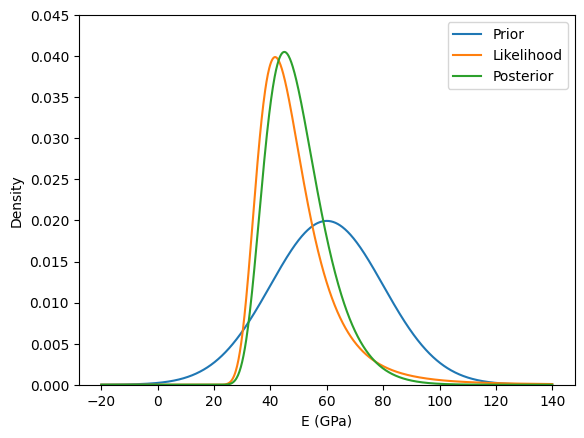

In [ ]:
plt.plot(E_values, prior_values, label='Prior')
plt.plot(E_values, likelihood_values, label='Likelihood')
plt.plot(E_values, posterior_values, label='Posterior')
plt.xlabel('E (GPa)')
plt.ylabel('Density')
plt.ylim([0, 0.045])
plt.legend()
plt.show()

:::{note} Complete Code! 📃💻
:class: dropdown
Here’s the complete code that you would run in your PC:

```python

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Fixed parameters
I = 1e9  # mm^4
L = 10_000  # mm
Q = 100  # kN

# Measurements
d_meas = 50  # mm
sigma_meas =  10  # mm

# Prior
E_mean = 60  # GPa
E_std = 20  # GPa

#forward model 
def midspan_deflection(E):
    return Q * L ** 3 / (48 * E * I)

def likelihood(E):
    return stats.norm.pdf(d_meas, loc=midspan_deflection(E), scale=sigma_meas)


def prior(E):
    return stats.norm.pdf(E, loc=E_mean, scale=E_std)

#numerical integration
E_values = np.linspace(-20, 140, 1000)
prior_values = prior(E_values)
likelihood_values = likelihood(E_values)

evidence = np.trapz(prior_values * likelihood_values, E_values)
posterior_values = prior_values * likelihood_values / evidence

#posterior summary
# Mean
mean = np.trapz(E_values * posterior_values, E_values)
print(f'Mean: {mean:.2f} GPa')

# Median
cdf = np.cumsum(posterior_values) * np.diff(E_values, prepend=0)
median = E_values[np.argmin(np.abs(cdf - 0.5))]
print(f'Median: {median:.2f} GPa')

# Standard deviation
std = np.sqrt(np.trapz((E_values - mean) ** 2 * posterior_values, E_values))
print(f'Standard deviation: {std:.2f} GPa')

# 5th and 95th percentiles
percentiles = np.interp([0.05, 0.95], cdf, E_values)
print(f'5th percentile: {percentiles[0]:.2f} GPa')
print(f'95th percentile: {percentiles[1]:.2f} GPa')

plt.plot(E_values, prior_values, label='Prior')
plt.plot(E_values, likelihood_values, label='Likelihood')
plt.plot(E_values, posterior_values, label='Posterior')
plt.xlabel('E (GPa)')
plt.ylabel('Density')
plt.ylim([0, 0.045])
plt.legend()

```
:::